# Plots with confidence interval

In [15]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import json
import numpy as np
from pbo.utils.confidence_interval import confidence_interval


parameters = json.load(open("parameters.json"))

max_bellman_iterations = 2
max_bellman_iterations_validation = max_bellman_iterations + 5
seeds = range(21, 41)
n_samples = parameters["n_discrete_states"] * parameters["n_discrete_actions"]
n_weights = parameters["n_weights"]
initial_weight_std = parameters["initial_weight_std"]
ticks_freq = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extract optimal

In [16]:
optimal_w = np.load(f"figures/data/optimal/W.npy")
optimal_pi = np.load(f"figures/data/optimal/Pi.npy")

pbo_optimal_w = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_W.npy")
pbo_optimal_pi = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_Pi.npy")

pbo_optimal_w_mean = np.sqrt(np.mean(np.square(pbo_optimal_w - optimal_w), axis=1))
pbo_optimal_pi_mean = np.abs(pbo_optimal_pi - optimal_pi)

## Investigation on the number of samples

In [17]:
n_samples_list = [3*3, 5*5, 11*11]
n_samples_colors = ["orange", "blue", "green"]

### Extrat data

In [18]:
pbo_custom_linear_w_n_samples = np.zeros((len(n_samples_list), len(seeds), max_bellman_iterations_validation + 1, 3))
pbo_custom_linear_pi_n_samples = np.zeros((len(n_samples_list), len(seeds), max_bellman_iterations_validation + 1))

for idx_n_samples, n_samples_ in enumerate(n_samples_list):
    for idx_seed, seed in enumerate(range(1, len(seeds) + 1)):
        pbo_custom_linear_w_n_samples[idx_n_samples, idx_seed] = np.load(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_W_{n_samples_}_{seed}.npy")
        pbo_custom_linear_pi_n_samples[idx_n_samples, idx_seed] = np.load(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_Pi_{n_samples_}_{seed}.npy")

### Distances with the optimal weights

In [19]:
pbo_custom_linear_w_mean_n_samples = np.zeros((len(n_samples_list), max_bellman_iterations_validation + 1))
pbo_custom_linear_w_confidence_interval_n_samples = np.zeros((len(n_samples_list), 2, max_bellman_iterations_validation + 1))

for idx_n_samples in range(len(n_samples_list)):
    pbo_custom_linear_w_mean_n_samples[idx_n_samples] = np.sqrt(np.mean(np.square(pbo_custom_linear_w_n_samples[idx_n_samples] - optimal_w), axis=2)).mean(axis=0)
    pbo_custom_linear_w_std_n_samples = np.sqrt(np.mean(np.square(pbo_custom_linear_w_n_samples[idx_n_samples] - optimal_w), axis=2)).std(axis=0)
    pbo_custom_linear_w_confidence_interval_n_samples[idx_n_samples] = confidence_interval(pbo_custom_linear_w_mean_n_samples[idx_n_samples], pbo_custom_linear_w_std_n_samples, len(seeds))

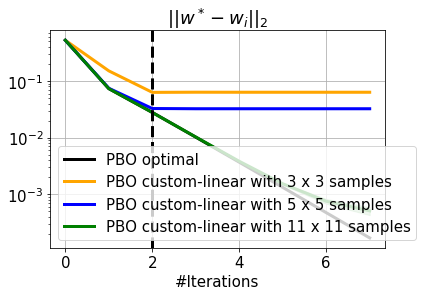

In [20]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_w_mean, label="PBO optimal", color="black")

for idx_n_samples, n_samples_ in enumerate(n_samples_list):
    plt.plot(iterations_validation, pbo_custom_linear_w_mean_n_samples[idx_n_samples], label=f"PBO custom-linear with {int(np.sqrt(n_samples_))} x {int(np.sqrt(n_samples_))} samples", color=n_samples_colors[idx_n_samples])
    plt.fill_between(iterations_validation, pbo_custom_linear_w_confidence_interval_n_samples[idx_n_samples, 0], pbo_custom_linear_w_confidence_interval_n_samples[idx_n_samples, 1], color=n_samples_colors[idx_n_samples], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.yscale("log")
plt.title(r"$|| w^* - w_i ||_2$")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_samples_distance_to_optimal_W_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distance to optimal value function

In [21]:
pbo_custom_linear_pi_mean_n_samples = np.zeros((len(n_samples_list), max_bellman_iterations_validation + 1))
pbo_custom_linear_pi_confidence_interval_n_samples = np.zeros((len(n_samples_list), 2, max_bellman_iterations_validation + 1))

for idx_n_samples in range(len(n_samples_list)):
    pbo_custom_linear_pi_mean_n_samples[idx_n_samples] = np.abs(pbo_custom_linear_pi_n_samples[idx_n_samples] - optimal_pi).mean(axis=0)
    pbo_custom_linear_pi_std_n_samples = np.abs(pbo_custom_linear_pi_n_samples[idx_n_samples] - optimal_pi).std(axis=0)
    pbo_custom_linear_pi_confidence_interval_n_samples[idx_n_samples] = confidence_interval(pbo_custom_linear_pi_mean_n_samples[idx_n_samples], pbo_custom_linear_pi_std_n_samples, len(seeds))

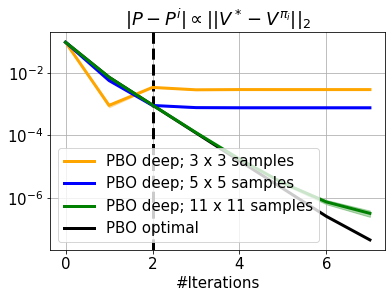

In [22]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)


for idx_n_samples, n_samples_ in enumerate(n_samples_list):
    plt.plot(iterations_validation, pbo_custom_linear_pi_mean_n_samples[idx_n_samples], label=f"PBO deep; {int(np.sqrt(n_samples_))} x {int(np.sqrt(n_samples_))} samples", color=n_samples_colors[idx_n_samples], zorder=8)
    plt.fill_between(iterations_validation, pbo_custom_linear_pi_confidence_interval_n_samples[idx_n_samples, 0], pbo_custom_linear_pi_confidence_interval_n_samples[idx_n_samples, 1], color=n_samples_colors[idx_n_samples], alpha=0.3)

plt.plot(iterations_validation, pbo_optimal_pi_mean, label="PBO optimal", color="black", zorder=4)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.yscale("log")
plt.title(r"$|P - P^i| \propto || V^* - V^{\pi_i} ||_2$")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_samples_distance_to_optimal_Pi_{max_bellman_iterations}.pdf", bbox_inches='tight')

## Investigation on the initial std

In [23]:
n_initial_weight_std_list = [1.0, 0.5, 0.0005]
n_initial_weight_std_legend = [r"$1$", r"$5 \times 10^{-1}$", r"$5 \times 10^{-4}$"]
n_initial_weight_std_colors = ["orange", "blue", "green"]

### Extract data

In [24]:
pbo_linear_w_n_initial_weight_std = np.zeros((len(n_initial_weight_std_list), len(seeds), max_bellman_iterations_validation + 2, 3))
pbo_linear_pi_n_initial_weight_std = np.zeros((len(n_initial_weight_std_list), len(seeds), max_bellman_iterations_validation + 2))

for idx_n_initial_weight_std, n_initial_weight_std_ in enumerate(n_initial_weight_std_list):
    for idx_seed, seed in enumerate(range(1, len(seeds) + 1)):
        pbo_linear_w_n_initial_weight_std[idx_n_initial_weight_std, idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_W_{n_initial_weight_std_}_{seed}.npy")
        pbo_linear_pi_n_initial_weight_std[idx_n_initial_weight_std, idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_Pi_{n_initial_weight_std_}_{seed}.npy")

### Distances with the optimal weights

In [25]:
pbo_linear_w_mean_n_initial_weight_std = np.zeros((len(n_initial_weight_std_list), max_bellman_iterations_validation + 2))
pbo_linear_w_confidence_interval_n_initial_weight_std = np.zeros((len(n_initial_weight_std_list), 2, max_bellman_iterations_validation + 2))

for idx_n_initial_weight_std in range(len(n_initial_weight_std_list)):
    pbo_linear_w_mean_n_initial_weight_std[idx_n_initial_weight_std] = np.sqrt(np.mean(np.square(pbo_linear_w_n_initial_weight_std[idx_n_initial_weight_std] - optimal_w), axis=2)).mean(axis=0)
    pbo_linear_w_std_n_initial_weight_std = np.sqrt(np.mean(np.square(pbo_linear_w_n_initial_weight_std[idx_n_initial_weight_std] - optimal_w), axis=2)).std(axis=0)
    pbo_linear_w_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std] = confidence_interval(pbo_linear_w_mean_n_initial_weight_std[idx_n_initial_weight_std], pbo_linear_w_std_n_initial_weight_std, len(seeds))

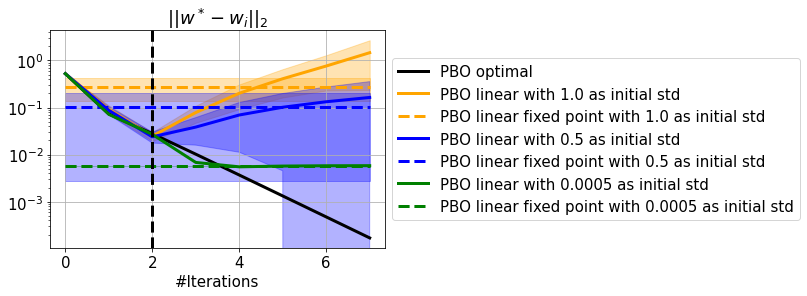

In [26]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_w_mean, label="PBO optimal", color="black")

for idx_n_initial_weight_std, n_initial_weight_std_ in enumerate(n_initial_weight_std_list):
    plt.plot(iterations_validation, pbo_linear_w_mean_n_initial_weight_std[idx_n_initial_weight_std, :-1], label=f"PBO linear with {n_initial_weight_std_} as initial std", color=n_initial_weight_std_colors[idx_n_initial_weight_std])
    plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 0, :-1], pbo_linear_w_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 1, :-1], color=n_initial_weight_std_colors[idx_n_initial_weight_std], alpha=0.3)

    plt.hlines(pbo_linear_w_mean_n_initial_weight_std[idx_n_initial_weight_std, -1], 0, max_bellman_iterations_validation, color=n_initial_weight_std_colors[idx_n_initial_weight_std], linestyle="--", label=f"PBO linear fixed point with {n_initial_weight_std_} as initial std")
    plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 0, -1], pbo_linear_w_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 1, -1], color=n_initial_weight_std_colors[idx_n_initial_weight_std], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.yscale("log")
plt.title(r"$|| w^* - w_i ||_2$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_initial_weight_std_distance_to_optimal_W_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distance to optimal value function

In [27]:
pbo_linear_pi_mean_n_initial_weight_std = np.zeros((len(n_initial_weight_std_list), max_bellman_iterations_validation + 2))
pbo_linear_pi_confidence_interval_n_initial_weight_std = np.zeros((len(n_initial_weight_std_list), 2, max_bellman_iterations_validation + 2))

for idx_n_initial_weight_std in range(len(n_initial_weight_std_list)):
    pbo_linear_pi_mean_n_initial_weight_std[idx_n_initial_weight_std] = np.abs(pbo_linear_pi_n_initial_weight_std[idx_n_initial_weight_std] - optimal_pi).mean(axis=0)
    pbo_linear_pi_std_n_initial_weight_std = np.abs(pbo_linear_pi_n_initial_weight_std[idx_n_initial_weight_std] - optimal_pi).std(axis=0)
    pbo_linear_pi_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std] = confidence_interval(pbo_linear_pi_mean_n_initial_weight_std[idx_n_initial_weight_std], pbo_linear_pi_std_n_initial_weight_std, len(seeds))

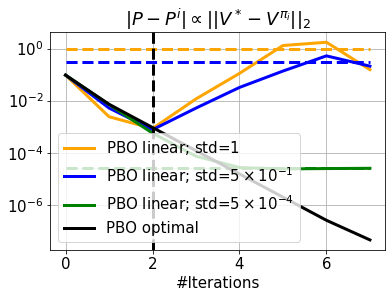

In [28]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

for idx_n_initial_weight_std, n_initial_weight_std_ in enumerate(n_initial_weight_std_list):
    plt.plot(iterations_validation, pbo_linear_pi_mean_n_initial_weight_std[idx_n_initial_weight_std, :-1], label="PBO linear; std=" + n_initial_weight_std_legend[idx_n_initial_weight_std], color=n_initial_weight_std_colors[idx_n_initial_weight_std])
    if n_initial_weight_std_ == 0.0005:
        plt.fill_between(iterations_validation, pbo_linear_pi_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 0, :-1], pbo_linear_pi_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 1, :-1], color=n_initial_weight_std_colors[idx_n_initial_weight_std], alpha=0.3)
    
    plt.hlines(pbo_linear_pi_mean_n_initial_weight_std[idx_n_initial_weight_std, -1], 0, max_bellman_iterations_validation, color=n_initial_weight_std_colors[idx_n_initial_weight_std], linestyle="--")
    if n_initial_weight_std_ == 0.0005:
        plt.fill_between(iterations_validation, pbo_linear_pi_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 0, -1], pbo_linear_pi_confidence_interval_n_initial_weight_std[idx_n_initial_weight_std, 1, -1], color=n_initial_weight_std_colors[idx_n_initial_weight_std], alpha=0.3)

plt.plot(iterations_validation, pbo_optimal_pi_mean, label="PBO optimal", color="black")

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.yscale("log")
plt.title(r"$|P - P^i| \propto || V^* - V^{\pi_i} ||_2$")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_initial_weight_std_distance_to_optimal_Pi_{max_bellman_iterations}.pdf", bbox_inches='tight')